In [1]:
import nltk
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from keras.models import load_model
from tqdm import tqdm
from tqdm import tqdm_notebook
from gensim import corpora
from gensim import models
from time import time
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore') 

# mecab = Mecab()
# okt = Okt()
# komoran=Komoran()
# hannanum=Hannanum()
kkma=Kkma()

C:\Users\manue\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 데이터 불러오기

In [2]:
df = pd.read_excel('Raw Data/(공유) 더샵약국몰_상담내역_2020.07-12.xlsx')
#(공유) 더샵약국몰_상담내역_2019.04-06.xlsx
#(공유) 더샵약국몰_상담내역_2019.07-12.xlsx
#(공유) 더샵약국몰_상담내역_2020.01-06.xlsx
#(공유) 더샵약국몰_상담내역_2020.07-12.xlsx
#(공유) 더샵약국몰_상담내역_2021.01-05.xlsx

In [3]:
df.head(3)

,상담일시,통화유형,상담구분,상담유형,상담상세,상담결과,문의사항
0,2020-12-31 18:04:48,발신,약국몰,이용문의,제품관련,VOC,\n\n태양약국-전상권 (해피톡)\n하일렌맥스0.3% 입고문의\n-> 입고미정\n-...
1,2020-12-31 17:58:20,수신,약국몰,이용문의,사은품/판촉물관련,완결,\n\n15만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 \n-> 담당자 있...
2,2020-12-31 17:57:25,발신,약국몰,이용문의,VIP전용관,완결,\n\nvip 전용관 낱알반품을 6개월 마다 모아서 하시는데 신청이 안된다고하심\n...


In [4]:
df.shape

(27691, 7)

# 문의사항 중 null 데이터 개수 확인

In [5]:
df['문의사항'].isnull().sum()

449

# 본문 중 null 데이터 제외

In [6]:
temp_idx = df[df['문의사항'].isnull()].index

In [7]:
df = df.drop(temp_idx)

In [8]:
df['문의사항'].isnull().sum()

0

In [9]:
df.shape

(27242, 7)

# 상담 내용 데이터 정제

In [10]:
import re
# from pykospacing import spacing

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    #for i in string.punctuation:
        #SW.add(i)
    SW.update(["요청", "완료", "안내", "확인", "반품", "결제", "약국", "신청", "배송", "취소", "가능", "문의", "주문", "구매"])
    SW.update(['예정', '연락', '처리', '대웅', '제품', '사용', '더샵', '발송', '업체', '변경', '방법', '안내드림', '쿠폰', '이벤트', '등록', '문자'])
    SW.update(['대웅제약', '상품', '적립', '이상', '카드', '금일', '승인', '해당', '전달', '거점', '수정', '담당자', '전화', '통화', '팩스'])
    SW.update(['다함', '진행', '오후', '사업자', '잔고', '할인', '금액', '오늘', '회수', '오산', '약사', '번호', '검색', '판매', '도착', '주소'])
    SW.update(['메일', '관리', '환불', '페이', '기간', '유효', '사유', '기사', '불가', '출고', '약품', '약속', '영업', '세금', '발행', '전체'])
    SW.update(['사원', '방문', '재고', '제조', '이오', '부분', '포장', '주문건', '관련', '박스', '공장', '반품건', '수량', '정지', '배송문', '제약'])
    SW.update(['즉시', '통장', '처방전', '포인트', '전용', '서비스', '보관', '복원', '대웅바이', '사용법', '선구매', '소멸', '적용', '개선', '오후시'])
    SW.update(['포인트몰', '선발행', '마감', '환입실', '등급', '지급', '서울지점', '삭제', '안내함', '구입', '연락처', '마일리지', '마이너스', '연락드림'])
    SW.update(['차장', '드림', '바이오', '이력', '어려움', '판촉물', '코드', '본인', '품절', '혜택', '직거래', '사입', '인천', '가입', '내일', '통화건'])
    SW.update(['예치금', '양해', '지연', '시간', '이후', '부재', '폐업', '오전', '내역', '여부', '연락드리', '교환', '접수', '이마트', '추가', '소비자'])
    SW.update(['특별', '경우', '수신', '공급관', '품목', '월요일', '중단', '상품권', '내용', '배정', '추후', '익일', '서울', '정보', '오류', '택배'])
    SW.update(['기존', '일자', '미배송', '시스템', '새벽', '당첨', '입금', '시분', '계좌', '국민', '통합', '복합', '이동', '오결재', '매핑', '향남'])
    SW.update(['참여', '역대', '성규', '가상', '채널', '스마', '김선', '산서', '이번', '상태', '공지', '어제', '입력', '매출', '전송', '장바구니'])
    SW.update(['소통', '사본', '지문', '소요', '기재', '조회', '다음', '고객', '발급', '도매', '부족', '연결', '오주문', '지역', '정도', '건강'])
    SW.update(['핸드폰', '가격', '종료', '인천약', '이용', '인수', '기한', '오주문', '부천시', '유통', '작업', '동물', '확인차', '알반품', '노출', '종료'])
    SW.update(['공급', '예정일', '건지', '송문', '품건', '현재', '거래', '계산서', '하심', '환입', '페이지', '전용관', '아이디', '지점', '카톡', '만우절'])
    SW.update(['필요', '결제완료', '반품신청', '확인요청', '만원', '취소요청', '영업사원', '있음', '기사님', '배송예정일', '배송예정', '문건', '유효기간', '취소완료','반품신청건', '주신', '백제'])
    SW.update(['수거', '통장사본', '구입문의', '명세표', '민정', '회원', '마트', '이전', '거래명세표', '배송문의', '희망', '누락', '이관', '거부', '회신', '확인후', '재연락', '이지'])
    SW.update(['마이너스잔고', '주시길', '안됨', '마이', '취소요청사유', '하다', '개월', '반품요청', '쿠폰사용', '지금', '개가', '인수', '인수인계', '주시', '온누리', '지금', '구매시', '당일', '세금계산서', '재발', '문의확인후', '바구니', '재발송'])
    SW.update(['제일', '제일헬스케어', '주심', '수령', '카드취소', '부탁', '양해드림'])
    #SW.update(["안내", "프로슈머", "요청", "긴급", "문의", "수정", "리스트", "감사", "관련", "부탁", "재문", "재문의", "추가", "제목", "등록", "정보"])
    #SW.update(['입니다', '또는', '추가', '드립니다', '드려요', '드릴게요', '가격', '합니다', '바랍니다', '부탁드립니다', '습니다', '지역', '급급', '월일'])
    #SW.update(['병원', '박일', '모두', '월호', '게시물', '위주', '드림', '의원', '투명', '이야기', '연세', '이비인후과', '에서'])
    #SW.update(['제공', '추천', '원내', '제작', '주력', '견적', '일정', '분석', '제작', '관리', '실장', '선생', '메일', '파일', '방법', '하나', '우리'])
    #SW.update(['구매', '후기', '테일', '구입', '이것저것', '이거', '직구', '추천', '가지', '오바', '성공', '주문', '오늘', '여러분', '하세', '오랜만','기타'])
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)

    return SW


def list_of_list(docs):
    temp_list = []
    
    for doc in docs:
        temp = doc.split(', ')
        temp_list.append(temp)
        
    return temp_list


def text_cleaning(docs):
    """
        1. 한글만 추출.
        
        2. 자음/모음 표현 처리방법.
        
            1) "ㅇㅇ" ,"ㅋㅋㅋㅋㅋ" 같은 자음만 존재하는 표현이나, "ㅡㅡ", "ㅠㅠ" 같은 모음만 존재하는 표현들은
            의미는 있으나 중요한 의미를 가지고 있지 않다고 판단하여 제거.
            
            2) 이러한 표현들도 전부 emoticon 같은 감정 표현의 의성어로 쓰거나, 단축 표현이므로 제거하지 않음. 
            
        3. http:// 로 시작하는 hyperlink 제거.
        
        4. 특수문자 제거.
        
        5. 이메일 주소 제거.
    
    """
    # Series의 object를 str로 변경.
    #docs = [str(doc) for doc in docs]
    
    # 1
    pattern1 = re.compile('[^ ㄱ-ㅣ가-힣]+')
    docs = [pattern1.sub("", docs)] 
    #print(docs)
    
    # 2
    pattern2 = re.compile("[ㄱ-ㅎ]*[ㅏ-ㅢ]*")
    docs = [pattern2.sub("", doc) for doc in docs]
    #print(docs)
    
    # 3
    #pattern3 = re.compile(r"\b(https?:\/\/)?([\w.]+){1,2}(\.[\w]{2,4}){1,2}(.*)")
    #docs = pattern3.sub("", docs) 
    
    # 4
    pattern4 = re.compile("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]")
    docs = pattern4.sub("", str(docs))
    #print(docs)
    
    # 5
    pattern5 = re.compile('\S*@\S*\s?')
    docs = pattern5.sub("", docs)
    #print(docs)
    
    # 띄어쓰기 다시하기
    # docs = spacing(docs)
    #print(docs)
    
    print('Done!')
        
    return docs


def slicing_time_str(time_str):
    return time_str[0:10]

# 본문 데이터 정제 후 본문클리닝에 저장

In [11]:
df['문의사항_클리닝'] = df['문의사항'].apply(text_cleaning)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

In [12]:
df.head()

,상담일시,통화유형,상담구분,상담유형,상담상세,상담결과,문의사항,문의사항_클리닝
0,2020-12-31 18:04:48,발신,약국몰,이용문의,제품관련,VOC,\n\n태양약국-전상권 (해피톡)\n하일렌맥스0.3% 입고문의\n-> 입고미정\n-...,태양약국전상권 해피톡하일렌맥스 입고문의 입고미정 처방전 받아논 상태로 입고시 꼭 연...
1,2020-12-31 17:58:20,수신,약국몰,이용문의,사은품/판촉물관련,완결,\n\n15만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 \n-> 담당자 있...,만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 담당자 있는처로 확인되어 해...
2,2020-12-31 17:57:25,발신,약국몰,이용문의,VIP전용관,완결,\n\nvip 전용관 낱알반품을 6개월 마다 모아서 하시는데 신청이 안된다고하심\n...,전용관 낱알반품을 개월 마다 모아서 하시는데 신청이 안된다고하심 매월 주차에 신청...
3,2020-12-31 17:54:33,발신,약국몰,배송관련,단순배송확인/ 요청,완결,\n\n결제완료(2020-12-30 20:39:07) PO1021291320 복산...,결제완료 복산나이스팜서울 배송예정일 오후 시 하기건 배송안와서 문의 복산나이스...
4,2020-12-31 17:54:32,수신,약국몰,배송관련,단순배송확인/ 요청,완결,\n\n지금 대웅제약 구매시 언제 배송인지 문의\n-> 주문마감시간 2021.01....,지금 대웅제약 구매시 언제 배송인지 문의 주문마감시간 오전 시배송예정일 오후 시


## 혹시 모를 상황에 대비해서 전처리된 데이터 프레임을 저장

In [13]:
df.to_csv('Data/2020.07-12_상담내역.csv', index = False, encoding = 'utf-8')

In [14]:
temp = pd.read_csv('Data/2020.07-12_상담내역.csv', encoding='utf-8')
temp.head()

,상담일시,통화유형,상담구분,상담유형,상담상세,상담결과,문의사항,문의사항_클리닝
0,2020-12-31 18:04:48,발신,약국몰,이용문의,제품관련,VOC,\n\n태양약국-전상권 (해피톡)\n하일렌맥스0.3% 입고문의\n-> 입고미정\n-...,태양약국전상권 해피톡하일렌맥스 입고문의 입고미정 처방전 받아논 상태로 입고시 꼭 연...
1,2020-12-31 17:58:20,수신,약국몰,이용문의,사은품/판촉물관련,완결,\n\n15만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 \n-> 담당자 있...,만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 담당자 있는처로 확인되어 해...
2,2020-12-31 17:57:25,발신,약국몰,이용문의,VIP전용관,완결,\n\nvip 전용관 낱알반품을 6개월 마다 모아서 하시는데 신청이 안된다고하심\n...,전용관 낱알반품을 개월 마다 모아서 하시는데 신청이 안된다고하심 매월 주차에 신청...
3,2020-12-31 17:54:33,발신,약국몰,배송관련,단순배송확인/ 요청,완결,\n\n결제완료(2020-12-30 20:39:07) PO1021291320 복산...,결제완료 복산나이스팜서울 배송예정일 오후 시 하기건 배송안와서 문의 복산나이스...
4,2020-12-31 17:54:32,수신,약국몰,배송관련,단순배송확인/ 요청,완결,\n\n지금 대웅제약 구매시 언제 배송인지 문의\n-> 주문마감시간 2021.01....,지금 대웅제약 구매시 언제 배송인지 문의 주문마감시간 오전 시배송예정일 오후 시


# 상담일시 판다스 포멧에 맞게 전환

In [15]:
df = pd.read_csv('Data/2020.07-12_상담내역.csv', encoding='utf-8')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27242 entries, 0 to 27241
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   상담일시      27242 non-null  object
 1   통화유형      27242 non-null  object
 2   상담구분      27242 non-null  object
 3   상담유형      27242 non-null  object
 4   상담상세      27241 non-null  object
 5   상담결과      27242 non-null  object
 6   문의사항      27242 non-null  object
 7   문의사항_클리닝  27186 non-null  object
dtypes: object(8)
memory usage: 1.7+ MB


In [17]:
df['상담일시'] = df['상담일시'].apply(slicing_time_str)
df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27242 entries, 0 to 27241
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   상담일시      27242 non-null  datetime64[ns]
 1   통화유형      27242 non-null  object        
 2   상담구분      27242 non-null  object        
 3   상담유형      27242 non-null  object        
 4   상담상세      27241 non-null  object        
 5   상담결과      27242 non-null  object        
 6   문의사항      27242 non-null  object        
 7   문의사항_클리닝  27186 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.7+ MB


In [19]:
df.head(3)

,상담일시,통화유형,상담구분,상담유형,상담상세,상담결과,문의사항,문의사항_클리닝
0,2020-12-31,발신,약국몰,이용문의,제품관련,VOC,\n\n태양약국-전상권 (해피톡)\n하일렌맥스0.3% 입고문의\n-> 입고미정\n-...,태양약국전상권 해피톡하일렌맥스 입고문의 입고미정 처방전 받아논 상태로 입고시 꼭 연...
1,2020-12-31,수신,약국몰,이용문의,사은품/판촉물관련,완결,\n\n15만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 \n-> 담당자 있...,만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 담당자 있는처로 확인되어 해...
2,2020-12-31,발신,약국몰,이용문의,VIP전용관,완결,\n\nvip 전용관 낱알반품을 6개월 마다 모아서 하시는데 신청이 안된다고하심\n...,전용관 낱알반품을 개월 마다 모아서 하시는데 신청이 안된다고하심 매월 주차에 신청...


# 월별 문의사항 데이터 TF-IDF 분석

In [20]:
df['문의사항_클리닝'].isnull().sum()

56

In [21]:
idx = df[df['문의사항_클리닝'].isnull()].index
df = df.drop(idx)

In [22]:
SW = define_stopwords("stopwords-ko.txt")

In [23]:
def list_of_list(docs):
    temp_list = []
    
    for doc in docs:
        temp = doc.split(', ')
        temp_list.append(temp)
        
    return temp_list

In [24]:
def month_context_extract_tfidf(df, month_start, month_end):
    
    # 시간정보 열 datetime 정보로 변환
    df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')
    #연도, 월 데이터 dataframe 받음
    year_month_df = df.loc[(df['상담일시'] > month_start) & (df['상담일시'] < month_end)]
    #제목 데이터 프레임 슬라이싱
    corpus = year_month_df['문의사항_클리닝']
    #리스트화
    cleaned_corpus = corpus.tolist() #--> list of str
    
    #okt를 이용한 형태소 분석
    temp_list = []
    for i in tqdm_notebook(cleaned_corpus):
        #temp_list.append(okt.morphs(i)) #temp_list.append(okt.nouns(i)) #명사형 
        #temp_list.append(mecab.morphs(i)) #temp_list.append(mecab.nouns(i))
        #temp_list.append(komoran.morphs(i)) #temp_list.append(komoran.nouns(i))
        #temp_list.append(hannanum.morphs(i)) #temp_list.append(hannanum.nouns(i))
        temp_list.append(kkma.nouns(i)) #temp_list.append(kkma.nouns(i))
    #2차원 리스트를 1차원으로    
    single_de_list = sum(temp_list, [])
    #불용어 제거
    final_list = [word for word in single_de_list if word not in SW and len(word) > 1]
    return final_list

In [25]:
# vectorizer 내에서 높은 순위로 고려되는 단어들을 불러오는 함수를 생성 
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) # 문서마다 단어의 tfidf 합산
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) # 단어의 tfidf 값 매핑하여 리스트에 추가
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    #ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    # tfidf 내림차순으로 정렬하여 데이터프레임 생성  
    return ranked 

In [26]:
df.head(3)

,상담일시,통화유형,상담구분,상담유형,상담상세,상담결과,문의사항,문의사항_클리닝
0,2020-12-31,발신,약국몰,이용문의,제품관련,VOC,\n\n태양약국-전상권 (해피톡)\n하일렌맥스0.3% 입고문의\n-> 입고미정\n-...,태양약국전상권 해피톡하일렌맥스 입고문의 입고미정 처방전 받아논 상태로 입고시 꼭 연...
1,2020-12-31,수신,약국몰,이용문의,사은품/판촉물관련,완결,\n\n15만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 \n-> 담당자 있...,만원이상 구매 시 사은품 받는다는데 자신은 보이지않음 담당자 있는처로 확인되어 해...
2,2020-12-31,발신,약국몰,이용문의,VIP전용관,완결,\n\nvip 전용관 낱알반품을 6개월 마다 모아서 하시는데 신청이 안된다고하심\n...,전용관 낱알반품을 개월 마다 모아서 하시는데 신청이 안된다고하심 매월 주차에 신청...


In [27]:
tfidf_corpus = month_context_extract_tfidf(df,'2020-07-01', '2020-12-31') #2019년 4월에서 6월까지 하려면 (df,'2019-04-01', '2019-06-30')로 작성하면 됨.
tfidf_corpus

['테일러',
 '유기농',
 '푸룬',
 '푸룬주스',
 '주스',
 '최저',
 '반영',
 '관련부서',
 '부서',
 '휴무',
 '다음주',
 '말씀',
 '말씀드림',
 '장지',
 '장지윤님',
 '대지인',
 '지인',
 '시크',
 '시크릿단가',
 '단가',
 '프로',
 '프로모션',
 '모션',
 '진행중',
 '차액',
 '모바렌',
 '입고시',
 '고시',
 '문자요청',
 '당장',
 '한번',
 '심추후',
 '양해안',
 '해안',
 '통화종료',
 '전환',
 '반품처리',
 '확인방법',
 '마이페이지예치금',
 '낱알',
 '낱알반품',
 '이월',
 '이월가능',
 '후연락',
 '보덕',
 '보덕메디',
 '메디',
 '전종우',
 '종우',
 '협의',
 '연초',
 '요청주시',
 '위내',
 '약국안내',
 '테일러',
 '유기농',
 '푸룬',
 '푸룬주스',
 '주스',
 '최저',
 '반영',
 '관련부서',
 '부서',
 '휴무',
 '다음주',
 '상아',
 '상아전자',
 '전자',
 '조은',
 '맥반석',
 '황토',
 '황토찜질기분',
 '찜질',
 '기분',
 '자동',
 '자동타이머기능',
 '타이머',
 '기능',
 '사유제품',
 '헬스',
 '헬스인',
 '신청되있음안내',
 '청되',
 '공동',
 '공동사업자',
 '대표',
 '단독',
 '단독변경',
 '나머지',
 '정보변경',
 '사업자번호',
 '면허증',
 '면허증사업자',
 '모두',
 '발송요청',
 '정보변경있음',
 '넥스',
 '넥스케어',
 '케어',
 '냉온',
 '냉온찜질팩',
 '찜질',
 '시배송예정',
 '배송확인요청',
 '곗음',
 '안내대',
 '통운',
 '정상',
 '정상출고',
 '배송사',
 '배송예정임',
 '곤지',
 '곤지암허브안내',
 '허브',
 '운영',
 '후임',
 '후임약사',
 '신규',
 '반품시',
 '연락주시',
 '계약',
 '연장',
 '관련사항',
 '사항',
 '지

In [28]:
len(tfidf_corpus)

284460

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
                            use_idf=True,
                            ngram_range=(1,1)) #오직 1-grams만 고려함
#                             min_df = 0.01,     #1% 미만으로 문서에서 출현하는 단어들은 삭제
#                             max_df = 0.05)      #5% 이상으로 문서에서 존재하는 단어들은 삭제(너무 흔함)

t0=time() 


tfidf = vectorizer.fit_transform(tfidf_corpus)

print("완료시간 : %0.3f초" % (time() - t0))

완료시간 : 2.431초


<AxesSubplot:xlabel='rank', ylabel='term'>

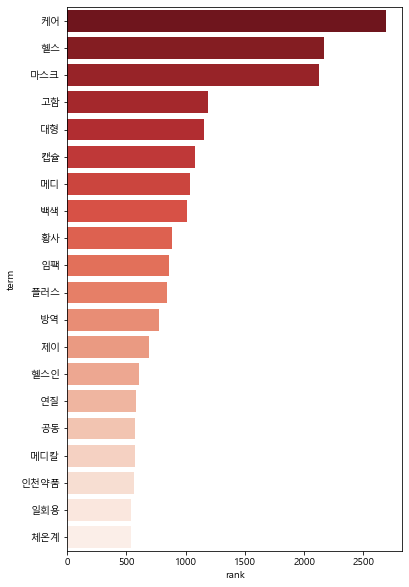

In [30]:
ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fix, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette="Reds_r", ax=ax)

# 월별 문의사항 데이터 Gensim 분석

In [31]:
def text_tokenizing(corpus, tokenizer):
    
    # okt = Okt()
    kkma=Kkma()
    token_corpus = []
    

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            # token_text = okt.nouns(corpus[n])
            #token_text = mecab.nouns(corpus[n])
            token_text = kkma.nouns(corpus[n])
            #token_text = komoran.nouns(corpus[n])
            #token_text = hannanum.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            
    elif tokenizer == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            # token_text = okt.morphs(corpus[n])
            #token_text = mecab.morphs(corpus[n])
            token_text = kkma.morphs(corpus[n])
            #token_text = komoran.morphs(corpus[n])
            #token_text = hannanum.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            

    return token_corpus

In [32]:
def month_context_extract_gensim(df, month_start, month_end):
    
    # 시간정보 열 datetime 정보로 변환
    df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')
    #연도, 월 데이터 dataframe 받음
    year_month_df = df.loc[(df['상담일시'] > month_start) & (df['상담일시'] < month_end)]
    #텍스트 정제
    corpus = year_month_df[['문의사항_클리닝']].values.tolist()
    #corpus --> list of list
    temp_list = sum(corpus, [])
    #okt 형태소 추출
    per_month_keyword = text_tokenizing(temp_list, "noun")
    
    
    return per_month_keyword

In [33]:
#2019년 4월에서 6월까지 하려면 (df,'2019-04-01', '2019-06-30')로 작성하면 됨.
gensim_corpus = month_context_extract_gensim(df, '2020-07-01', '2020-12-31') 

In [34]:
gensim_corpus

[['테일러',
  '유기농',
  '푸룬',
  '푸룬주스',
  '주스',
  '최저',
  '반영',
  '관련부서',
  '부서',
  '휴무',
  '다음주',
  '말씀',
  '말씀드림',
  '장지',
  '장지윤님',
  '대지인',
  '지인',
  '시크',
  '시크릿단가',
  '단가',
  '프로',
  '프로모션',
  '모션',
  '진행중',
  '차액'],
 ['모바렌', '입고시', '고시', '문자요청', '당장', '한번', '심추후', '양해안', '해안', '통화종료'],
 ['전환', '반품처리', '확인방법', '마이페이지예치금'],
 ['낱알',
  '낱알반품',
  '이월',
  '이월가능',
  '후연락',
  '보덕',
  '보덕메디',
  '메디',
  '전종우',
  '종우',
  '협의',
  '연초',
  '요청주시',
  '위내',
  '약국안내'],
 ['테일러', '유기농', '푸룬', '푸룬주스', '주스', '최저', '반영', '관련부서', '부서', '휴무', '다음주'],
 ['상아',
  '상아전자',
  '전자',
  '조은',
  '맥반석',
  '황토',
  '황토찜질기분',
  '찜질',
  '기분',
  '자동',
  '자동타이머기능',
  '타이머',
  '기능',
  '사유제품',
  '헬스',
  '헬스인',
  '신청되있음안내',
  '청되'],
 ['공동',
  '공동사업자',
  '대표',
  '단독',
  '단독변경',
  '나머지',
  '정보변경',
  '사업자번호',
  '면허증',
  '면허증사업자',
  '모두',
  '발송요청',
  '정보변경있음'],
 ['넥스',
  '넥스케어',
  '케어',
  '냉온',
  '냉온찜질팩',
  '찜질',
  '시배송예정',
  '배송확인요청',
  '곗음',
  '안내대',
  '통운',
  '정상',
  '정상출고',
  '배송사',
  '배송예정임',
  '곤지',
  '곤지암허브안내',
  '허브'],
 [

In [35]:
len(gensim_corpus)

26836

Building document-term matrix.

Printing topic words.

Topic ID: 0
	마스크	0.01719905622303486
	케어	0.015453338623046875
	헬스	0.014279897324740887
	대형	0.008237924426794052
	백색	0.007949165999889374
	일회용	0.0062761325389146805
	황사	0.00558624230325222
	방역	0.00510563887655735
	메디	0.004902963992208242
	헬스인	0.004115344025194645
	고함	0.003954061307013035
	플러스	0.0038613046053797007
	매입	0.0035224263556301594
	캡슐	0.0035057414788752794
	회수요청	0.003381685819476843
	낱알	0.003194232238456607
	필터	0.00302873901091516
	체온계	0.0029722885228693485
	단순	0.0028988714329898357
	세화	0.0026596812531352043
	반품가능	0.0026124536525458097
	청해	0.0023451484739780426
	헬스케어	0.0023176325485110283
	메디칼	0.002314877463504672
	차단	0.0023005278781056404
	인천약품	0.00226572691462934
	운수	0.0022498283069580793
	반품신청요청	0.002244823146611452
	트레이드	0.002241280162706971
	성인	0.0022378312423825264


Topic ID: 1
	임팩	0.005263312719762325
	제이	0.0046893153339624405
	고함	0.004579633474349976
	티제이	0.0028806065674871206
	캡슐	0.0026315709110349417
	해당건	0.00260

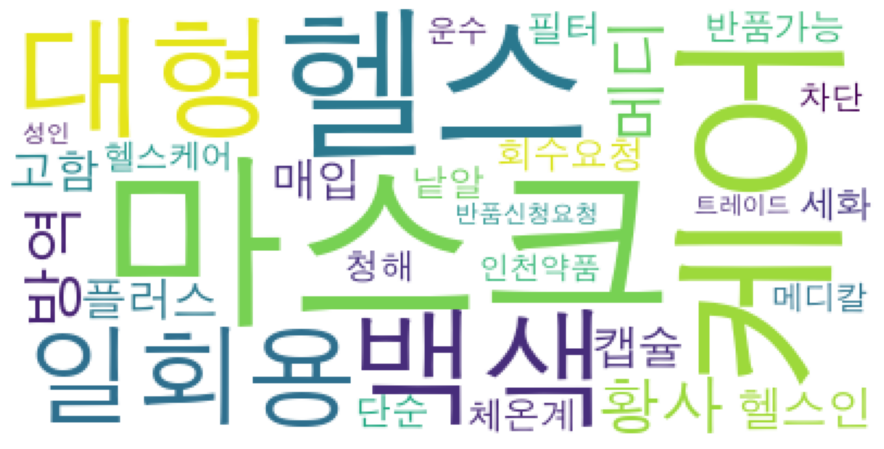

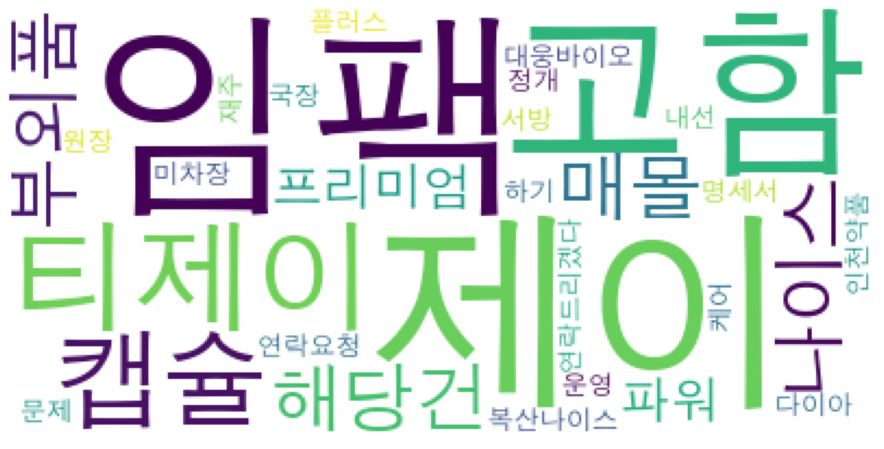

In [36]:
# 토픽 개수, 키워드 개수를 정해주는 변수를 추가.
NUM_TOPICS = 2

NUM_TOPIC_WORDS = 30


def build_doc_term_mat(documents):
    # 문서-단어 행렬 만들어주는 함수.
    print("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]
        
    return corpus, dictionary


def print_topic_words(model):

    # 토픽 모델링 결과를 출력해 주는 함수.
    print("\nPrinting topic words.\n")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
            
        print("\n")

def word_cloud(model):
    for topic_id in range(model.num_topics):
        wordcloud = WordCloud(font_path='Font/applegothic.ttf',
                          relative_scaling = 0.2,
                          # stopwords=STOPWORDS,
                          background_color='white',
                          ).generate_from_frequencies(dict(model.show_topic(topic_id,NUM_TOPIC_WORDS)))
        plt.figure(figsize=(16,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        print("\n\n")
        
        
# document-term matrix를 만들고,
corpus, dictionary = build_doc_term_mat(gensim_corpus)
# LDA를 실행.
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
# 결과를 출력.
print_topic_words(model)
#워드 클라우드 출력
word_cloud(model)

In [37]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = gensimvis.prepare(model, corpus, model.id2word)
pyLDAvis.display(data)

C:\Users\manue\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [38]:
pyLDAvis.save_html(data,'202007-12_kkma_lda.html')

C:\Users\manue\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 월별 문의사항 데이터 KR-wordrank 분석

참조 사이트: https://pypi.org/project/krwordrank/

In [26]:
from krwordrank.word import KRWordRank

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
min_count = 5   # 단어의 최소 출현 빈도수 (그래프 생성 시)
max_length = 10 # 단어의 최대 길이
wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10
texts = tfidf_corpus #1차원인 list가 필요해 tfidf에서 쓰인 corpus를 그대로 사용함.
keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
        print('%8s:\t%.4f' % (word, r))

      플러:	2.7769
     마일리:	2.7054
      이벤:	2.5283
      포인:	2.4820
      담당:	2.2132
      주문:	1.5727
      이마:	1.5708
      바이:	1.5707
      제이:	1.5478
      예치:	1.5256
      국민:	1.4880
      어려:	1.4270
      전용:	1.3967
     스트로:	1.3859
      프로:	1.3499
      신용:	1.2902
      상품:	1.2789
      나이:	1.2669
      연락:	1.2028
      마이:	1.1553
      된다:	1.1308
      메디:	1.0780
      계산:	1.0664
      종이:	1.0651
     프리미:	1.0367
      판촉:	1.0312
      스위:	1.0000
      현금:	1.0000
      카라:	1.0000
      장바:	1.0000


/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
SW

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'가\n',
 '가까스로\n',
 '가령\n',
 '각\n',
 '각각\n',
 '각자\n',
 '각종\n',
 '갖고말하자면\n',
 '같다\n',
 '같이\n',
 '개의치않고\n',
 '거니와\n',
 '거바\n',
 '거의\n',
 '것\n',
 '것과 같이\n',
 '것들\n',
 '게다가\n',
 '게우다\n',
 '겨우\n',
 '견지에서\n',
 '결과에 이르다\n',
 '결국\n',
 '결론을 낼 수 있다\n',
 '겸사겸사\n',
 '고려하면\n',
 '고로\n',
 '곧\n',
 '공동으로\n',
 '과\n',
 '과연\n',
 '관계가 있다\n',
 '관계없이\n',
 '관련이 있다\n',
 '관하여\n',
 '관한\n',
 '관해서는\n',
 '구\n',
 '구체적으로\n',
 '구토하다\n',
 '그\n',
 '그들\n',
 '그때\n',
 '그래\n',
 '그래도\n',
 '그래서\n',
 '그러나\n',
 '그러니\n',
 '그러니까\n',
 '그러면\n',
 '그러므로\n',
 '그러한즉\n',
 '그런 까닭에\n',
 '그런데\n',
 '그런즉\n',
 '그럼\n',
 '그럼에도 불구하고\n',
 '그렇게 함으로써\n',
 '그렇지\n',
 '그렇지 않다면\n',
 '그렇지 않으면\n',
 '그렇지만\n',
 '그렇지않으면\n',
 '그리고\n',
 '그리하여\n',
 '그만이다\n',
 '그에 따르는\n',
 '그위에\n',
 '그저\n',
 '그중에서\n',
 '그치지 않다\n',
 '근거로\n',
 '근거하여\n',
 '기대여\n',
 '기점으로\n',
 '기준으로\n',
 '기타\n',
 '까닭으로\n',
 '까악\n',
 '까지\n',
 '까지 미치다\n',
 '까지도\n',
 '꽈당\n',
 '끙끙\n',
 '끼익\n',
 '나\n',
 '나머지는\n',
 '남들\n',
 '남짓\n',
 '너\n',
 '너희\n',
 '너희들\n',
 '네\n',
 '넷\n',
 '년\n',
 '논하지 않다\n',
 '놀라다\n',

In [31]:
stopwords = SW
passwords = {word:score for word, score in sorted(
    keywords.items(), key=lambda x:-x[1])[:300] if not (word in stopwords)}

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
krwordrank_cloud = WordCloud(
    font_path = '/Library/Fonts/AppleGothic.ttf',
    width = 800,
    height = 800,
    background_color="white"
)
krwordrank_cloud = krwordrank_cloud.generate_from_frequencies(passwords)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


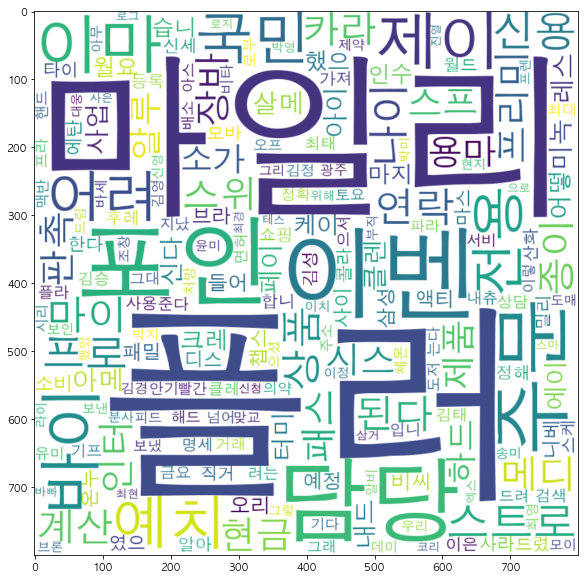

In [33]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(krwordrank_cloud, interpolation="bilinear")
plt.show()

In [ ]:
fig.savefig('./lalaland_wordcloud.png') #그림 저장